In [1]:
import math

import numpy as np

from cospar import reader, F, paramkeys, datakeys

from everest.window import Canvas
from everest.window.data import Data
from everest.analysis import time_smooth, time_fourier
from matplotlib.pyplot import get_cmap
%matplotlib inline

In [2]:
cut = reader[(F('aspect') == 1) & (F('temperatureField') == '_built_peaskauslu-thoesfthuec')]

In [3]:
fs = (0.5, 0.6, 0.7, 0.8, 0.9, 1.0)

allDatas = []

for f in fs:

    subcut = cut & reader[F('f') == f]
    datas = reader[subcut : ('tauRef', 'Nu', 'VRMS', 'velAng_outer_av', 'yieldFrac', 't')]
    datas = sorted(datas.values(), key = lambda d: d[0])

    tauRefs = np.empty(len(datas))
    avNus = np.empty(len(datas))
    avVRMS = np.empty(len(datas))
    avSurfVels = np.empty(len(datas))
    avYieldFracs = np.empty(len(datas))
    domFreqs = np.empty(len(datas))

    for i, (tauRef, Nu, VRMS, surfVel, yieldFrac, t) in enumerate(datas):

        mask = t > (max(t) - max(t) * 2 ** -1.5)
        freqs, trans = time_fourier(
            t[mask],
            Nu[mask],
            sampleFactor = 10,
            interpKind = 'quadratic',
            minFreq = 0.01,
            maxFreq = 100.,
            minAmps = (2,),
            )
        domFreqs[i] = freqs[list(trans).index(np.max(trans))]

        tauRefs[i] = tauRef
        t, Nu, VRMS, surfVel, yieldFrac = time_smooth(t, Nu, VRMS, surfVel, yieldFrac, sampleFactor = 1)
        mask = t > (max(t) - max(t) * 2 ** -1.5)
        avNus[i] = np.mean(Nu[mask])
        avVRMS[i] = np.mean(VRMS[mask])
        avSurfVels[i] = np.mean(surfVel[mask])
        avYieldFracs[i] = np.mean(yieldFrac[mask])

    allDatas.append((tauRefs, avNus, avVRMS, avSurfVels, avYieldFracs, domFreqs))

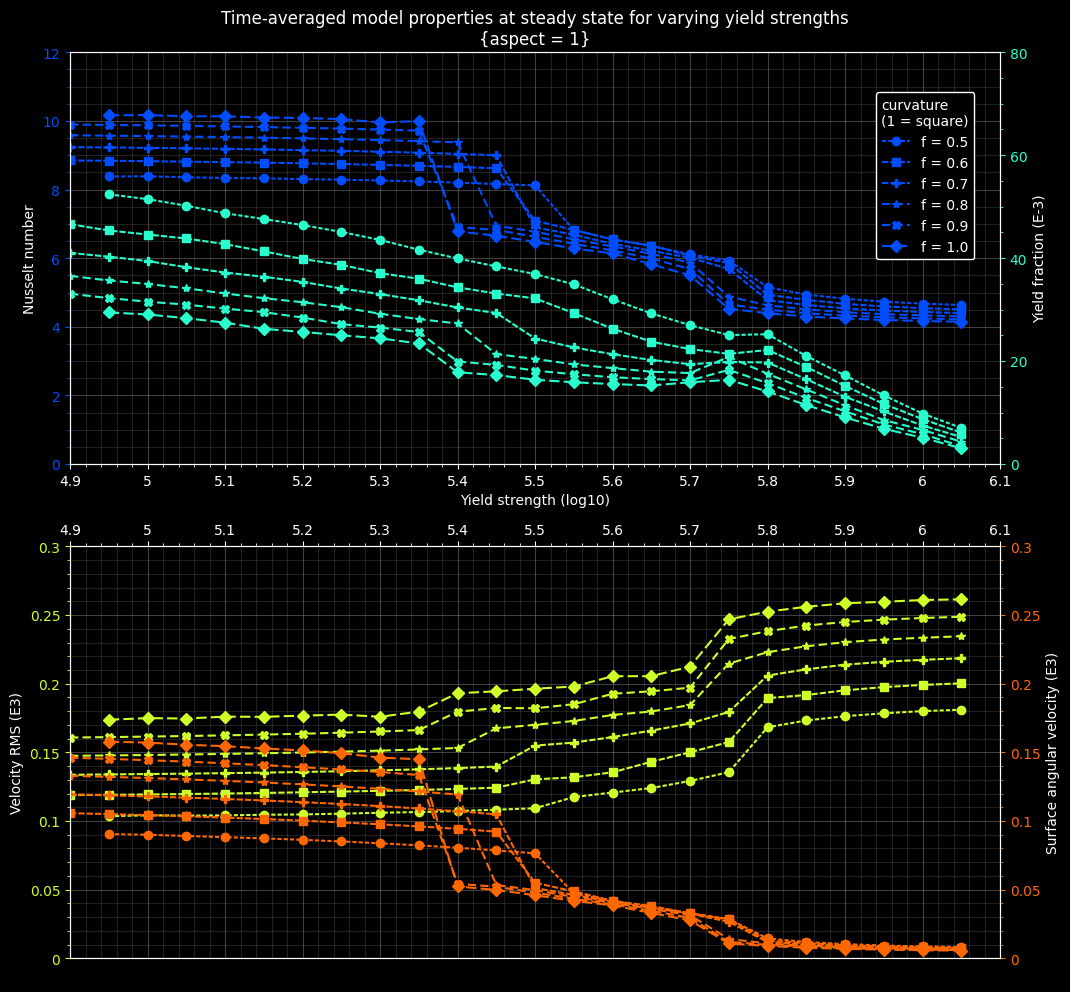

In [12]:
canvas = Canvas(shape = (2, 1), size = (12, 12), facecolour = 'black')
ax1, ax2 = canvas.make_ax(), canvas.make_ax()
ax3, ax4 = canvas.make_ax(place = (1, 0)), canvas.make_ax(place = (1, 0))

allAxs = (ax1, ax2, ax3, ax4)
ax1col = get_cmap('jet')(0.2)
ax2col = get_cmap('jet')(0.4)
ax3col = get_cmap('jet')(0.6)
ax4col = get_cmap('jet')(0.8)
allCols = (ax1col, ax2col, ax3col, ax4col)

markers = dict(zip(fs, ('o', 's', 'P', '*', 'X', 'D')))
for f, (tauRefs, avNus, avVRMS, avSurfVel, avYieldFrac, *_) in zip(fs, allDatas):
#     if f != 1: continue
    x = Data(np.log10(tauRefs), label = 'Yield strength (log10)', lims = (4.9, 6.1), capped = (True, True))
    linestyle = (0, (int(f * 10 / 2), int(f * 10 / 4)))
    marker = markers[f]
    styles = dict(marker = marker, linestyle = linestyle)
    ax1.line(
        x,
        Data(avNus, label = 'Nusselt number', lims = (0, 12)),
        c = ax1col,
        **styles,
        )
    ax2.line(
        x,
        Data(avYieldFrac, label = 'Yield fraction', lims = (0, 70 * 1e-3)),
        c = ax2col,
        **styles,
        )
    ax3.line(
        x,
        Data(avVRMS, label = 'Velocity RMS', lims = (0, 300)),
        c = ax3col,
        **styles,
        )
    ax4.line(
        x,
        Data(avSurfVel, label = 'Surface angular velocity', lims = (0, 300)),
        c = ax4col,
        **styles,
        )

for ax, axCol in zip(allAxs, allCols):
    ax.axes.colour = 'white'
    ax.ticks.x.colour = 'white'
    ax.ticks.y.colour = axCol
    ax.grid.colour = 'grey'
for ax in (ax2, ax4):
    ax.axes.y.swap()
    ax.grid.visible = False
    ax.axes.x.visible = False
ax3.axes.x.label = ''
ax3.axes.x.swap()
ax1.axes.title = 'Time-averaged model properties at steady state for varying yield strengths\n{aspect = 1}'

ax = canvas.axs[0][0][0]
legendHandles = [r[0] for r in ax.collections]
legendLabels = [f"f = {f}" for f in fs]
_, handles, labels = zip(*sorted(zip(fs, legendHandles, legendLabels)))
legend = ax.ax.legend(
    handles,
    labels,
    loc = 'right',
    framealpha = 1.,
    labelcolor = 'white',
    facecolor = 'black',
    frameon = True,
    title = 'curvature\n(1 = square)',
    bbox_to_anchor = (0.98, 0.7),
    )
legend.properties()['title'].set_color('white')
legend.get_frame().set_edgecolor('w')

canvas.show()

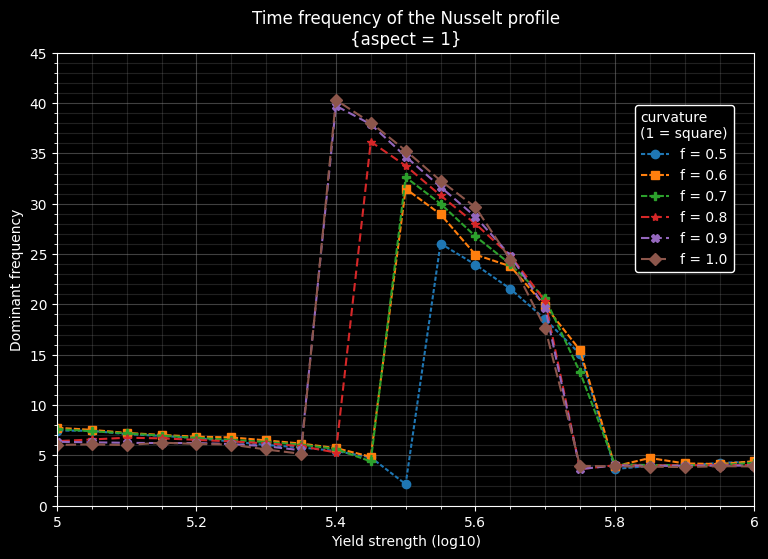

In [5]:
canvas = Canvas(size = (9, 6), facecolour = 'black')
ax = canvas.make_ax()
for f, (tauRefs, *_, domFreqs) in zip(fs, allDatas):
    linestyle = (0, (int(f * 10 / 2), int(f * 10 / 4)))
    marker = markers[f]
    ax.line(
        Data(np.log10(tauRefs), label = 'Yield strength (log10)', lims = (5., 6.), capped = (True, True)),
        Data(domFreqs, label = 'Dominant frequency'),
        marker = marker,
        linestyle = linestyle,
        )
ax.axes.colour = 'white'
ax.ticks.x.colour = 'white'
ax.ticks.y.colour = 'white'
ax.grid.colour = 'grey'
ax.axes.title = 'Time frequency of the Nusselt profile\n{aspect = 1}'

ax = canvas.axs[0][0][0]
legendHandles = [r[0] for r in ax.collections]
legendLabels = [f"f = {f}" for f in fs]
_, handles, labels = zip(*sorted(zip(fs, legendHandles, legendLabels)))
legend = ax.ax.legend(
    handles,
    labels,
    loc = 'right',
    framealpha = 1.,
    labelcolor = 'white',
    facecolor = 'black',
    frameon = True,
    title = 'curvature\n(1 = square)',
    bbox_to_anchor = (0.98, 0.7),
    )
legend.properties()['title'].set_color('white')
legend.get_frame().set_edgecolor('w')

canvas.show()

In [6]:
# datas = sorted(reader[cut & reader[F('f') == 0.5] : ('tauRef', 't', 'Nu')].values())

# canvas = Canvas(size = (12, 6), facecolour = 'black')
# ax = canvas.make_ax()
# logTaus = [math.log10(tau) for tau, *_ in datas]
# normTau = lambda tau: (math.log10(tau) - min(logTaus)) / (max(logTaus) - min(logTaus))
# cmap = get_cmap('viridis')
# for tauRef, t, Nu in datas:
#     ax.line(
#         Data(t, label = 'Dimensionless time'),
#         Data(Nu, label = 'Nusselt number'),
#         c = cmap(normTau(tauRef))
#         )

# ax.axes.colour = 'white'
# ax.ticks.x.colour = 'white'
# ax.ticks.y.colour = 'white'
# ax.grid.colour = 'grey'
# ax.axes.title = 'Nusselt number timeseries for varying yield stress\n{aspect = 1, curvature = 0.5}'

# legendValues = logTaus
# legendHandles = [r[0] for r in ax.collections]
# legendLabels = [str(round(v, 2)) for v in legendValues]
# handles, labels, _ = zip(*sorted(zip(legendHandles, legendLabels, legendValues), key = lambda r: r[-1]))
# legend = ax.ax.legend(
#     handles,
#     labels,
#     loc = 'right',
#     framealpha = 0.,
#     labelcolor = 'white',
#     title = 'tau0 (10^n)',
#     bbox_to_anchor = (1.12, 0.5),
#     )
# legend.properties()['title'].set_color('white')

# canvas.show()

In [7]:
# datas = sorted(reader[cut & reader[F('f') == 0.5] : ('tauRef', 't', 'Nu')].values())

# canvas = Canvas(size = (12, 6), facecolour = 'black')
# ax = canvas.make_ax()
# # tauFilt = lambda tauRef: 5.425 < math.log10(tauRef) < 5.8
# tauFilt = lambda tauRef: math.log10(tauRef) < 5.55
# logTaus = [math.log10(tau) for tau, *_ in datas if tauFilt(tau)]
# normTau = lambda tau: (math.log10(tau) - min(logTaus)) / (max(logTaus) - min(logTaus))
# cmap = get_cmap('plasma')
# for tauRef, t, Nu in datas:
#     if not tauFilt(tauRef): continue
#     ax.line(
#         Data(t, label = 'Dimensionless time'),
#         Data(Nu, label = 'Nusselt number'),
#         c = cmap(normTau(tauRef))
#         )

# ax.axes.colour = 'white'
# ax.ticks.x.colour = 'white'
# ax.ticks.y.colour = 'white'
# ax.grid.colour = 'grey'
# ax.axes.title = 'Nusselt number timeseries for varying yield stress\n{aspect = 1, curvature = 0.5}'

# legendValues = logTaus
# legendHandles = [r[0] for r in ax.collections]
# legendLabels = [str(round(v, 2)) for v in legendValues]
# handles, labels, _ = zip(*sorted(zip(legendHandles, legendLabels, legendValues), key = lambda r: r[-1]))
# legend = ax.ax.legend(
#     handles,
#     labels,
#     loc = 'right',
#     framealpha = 0.,
#     labelcolor = 'white',
#     title = 'tau0 (10^n)',
#     bbox_to_anchor = (1.12, 0.5),
#     )
# legend.properties()['title'].set_color('white')

# canvas.show()

In [8]:
# t, Nu = dict(((tauRef, vals) for tauRef, *vals in datas))[10 ** 5.5]
# canvas = Canvas(size = (12, 6))
# ax = canvas.make_ax()
# mask = t > (max(t) - max(t) * 2 ** -1.5)
# ax.line(
#     t[mask],
#     Nu[mask],
# #     Data(t, lims = (0.5, None)), 
# #     Data(Nu, lims = (8., 9.0)),
#     )
# canvas.show()

In [9]:
# from IPython.display import Video
# from everest.window.raster import animate
# %matplotlib inline
# pulled = reader[
#     cut & reader[(F('f') == 0.5) & (F('tauRef') == 10 ** 5.5)] \
#     : ('t', 'theta', 'psi', 'epsilon')]
# t, *datas = pulled[list(pulled.keys())[0]]
# myanim = animate(datas, t, pts = 0.1, size = (128, 128), outputPath = 'animations')
# Video(myanim, embed = True, width = 400)